## Optimization and quantum simulation of a model for partial and complete qubit state estimation

This Jupyter notebook has a brief but also complete application of the method proposed by [Saavedra and Romero](https://doi.org/10.1103/PhysRevA.99.042130) for doing complete qubit state tomography.

First we are setting up the problem. Here we want to estimate the three components of the Bloch vector that describes the initial state of a qubit $S$ without measuring the qubit itself. This can be done by using two auxiliary qubits, which we are going to call meters $A$ and $B$. These two meters interact with the qubit of interest in a way that, when we measure them, we can estimate the three components of the Bloch vector that describes the initial state of the qubit $S$.

For practical purposes of this notebook, the interaction between the qubits $S$, $A$ and $B$ is not going to be developed in detail. The main result is that the interaction can be written in terms of a Hamiltonian

$$H  = \left(\lambda_A\Pi^S_1 \otimes \Pi^A_1 \otimes I^B + \lambda_B \Pi^S_{+} \otimes I^A \otimes \Pi^B_1 \right),$$

where $\Pi_k^M = |k^M\rangle\langle k^M|$, with $k=1,+$ and $M=A,B$; $I_A$ and $I_B$ are identity operators associated to the Hilbert spaces of meters $A$ and $B$, respectively; and $\lambda_A$, $\lambda_B$ are constants. 
Here, $|{+}\rangle$ and $|{-}\rangle$ are the eigenstates of $\sigma_x.$
The corresponding time evolution operator, at time $T$, 

$$	U(\theta_A,\theta_B) = e^{-iHT/\hbar} =  \exp\left[-\frac{i}{\hbar}\int_{0}^{T} H(t) dt\right]=\exp\left(-i\theta_A\Pi^S_0 \otimes \Pi^A_0 \otimes I^B - i\theta_B \Pi^S_{+} \otimes I^A \otimes \Pi^B_0\right)$$

depends on the parameters $\theta_A =(\lambda_A T/\hbar)$ and $\theta_B = (\lambda_B T/\hbar)$.
With this in mind. We have enough tools for starting the implementation of this model in a quantum computer in order to see its performance in real quantum devices.

We first start by importing some libraries that we are going to use for the development of this project.


In [45]:
## Imports can be seen in the imports.ipynb file
%run imports.ipynb
IBMQ.load_account()
pi = np.pi
j = complex(0,1)

ibmqfactory.load_account:WARNING:2022-03-22 20:02:41,124: Credentials are already in use. The existing account in the session will be replaced.


### Qubits initialization

For this simulation, first, we have to initialize the qubits that we are going to use. In this case the $A$ and $B$ meters have to be initialized in the state $|+\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right)$. On the other hand, the qubit $S$ is initialized in an arbitrary state $|\psi^S\rangle = c_0|0\rangle + c_1 |1\rangle$. This state can be parametrized in terms of the angles of a $U$ gate,
$$U_{gate}(\theta,\phi,\lambda) = \begin{pmatrix}
\cos(\theta/2) & -e^{i\lambda}\sin(\theta/2) \\
e^{i\phi}\sin(\theta/2) & e^{i\lambda + i\phi}\cos(\theta/2) 
\end{pmatrix} .$$
So we define the initialization function.

In [2]:
def Initialization(angles = [0,0,0]):
    
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    #Initialice qubits
    qc.h(qr[0])                                    #A meter
    qc.h(qr[2])                                    #B meter
    qc.u(angles[0],angles[1],angles[2],[qr[1]])    #System
    
    Init_gate = qc.to_gate()
    Init_gate.name= "Initialization"
    
    return Init_gate

### Evolution operator

Now we have to implement the evolution operator. Since we are using qiskit for this simulation. We are going to use the qiskit `HamiltonianGate` class for defining a set of quantum gates that represent the time evolution operator.

In [3]:
def U_operator(th_A,th_B):

    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)
    
    #####==================================#####
    #####=========== Hamiltonian ==========#####
    #####==================================#####
    
    ## H is A x S x B
    
    HA=np.matrix([[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,th_A,0],[0,0,0,0,0,0,0,th_A]])
    HB=np.matrix([[0,0,0,0,0,0,0,0],[0,th_B,0,th_B,0,0,0,0],[0,0,0,0,0,0,0,0],[0,th_B,0,th_B,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,th_B,0,th_B],[0,0,0,0,0,0,0,0],[0,0,0,0,0,th_B,0,th_B]])

    H=HA+HB
    
    ## We take T = 1 so then the interaction parameters are actually the angles \theta_{A} and \theta_{B}
    U=Operator(qiskit.extensions.HamiltonianGate(H, 1))
    
    qc.append(U,[0,1,2])
    
    U_gate=qc.to_gate()
    U_gate.name="U Operator"

    return U_gate    

### Qubit state estimation
Now we have to do the estimation of the Bloch vector that describes the initial state of the qubit $S$. For this we are going to introduce the theoretical model briefly. First we have to change the basis where we are going to measure the meters $A$ and $B$.
After measuring we will find a set of counts of the four possible states, whose probabilities are going to be saved in a vector $\textbf{P} = (p_{00},p_{01},p_{10},p_{11})^T$. Then, whith this results, we now have to decompose the evolution operator in order to build the measurement matrix which will allows us to do the state estimation. We can use the completeness relation to decompose the evolution operator acting over the three qubits by 
$$\begin{aligned} |\Psi(T)\rangle &= U |\psi_0^S\rangle\otimes |+^A\rangle \otimes |+^B\rangle \\
&= \frac{1}{2}\sum_{ij=0,1}U_{ij} |\psi_0^S\rangle |i^A j^B\rangle .\end{aligned}$$

Here $i$ and $j$ are related to the results obtained for the measurement of the meter $A$ and $B$ respectively.
Now we have to define three operators that we called $A$, $B$, and $C$. This operators will be important for the definition of the measurement matrix. they have the form

$$A = \frac{1}{16}\sum_{ij}U_{ij}^\dagger U_{-ij}$$
$$B = \frac{1}{16}\sum_{ij}U_{ij}^\dagger U_{i -j}$$
$$C = \frac{1}{16}\sum_{ij}U_{ij}^\dagger U_{-i-j}$$

The minus sign indicates a negation of the result, so, if $i = 0$ then $ -i = 1$.

With this we can define some auxiliary vectors 
$$a_\mu = \frac{1}{2}Tr[A\sigma_\mu],$$
$$b_\mu = \frac{1}{2}Tr[B\sigma_\mu],$$
$$c_\mu = \frac{1}{2}Tr[C\sigma_\mu].$$
Where $\sigma_\mu = (1,\sigma_x,\sigma_y,\sigma_z).$ This vectors will be important for the definition of the measurement matrix which will be important later.

The probability $p_{kl}$ that meters A and B are detected in states $|k^A\rangle$ and $|{l^A}\rangle$, respectively, $k,l=\pm = \{0,1\},$ here $0$ represents the $-$ state and 1 represents the $+$ state, is
$$p_{kl} =  \frac{1}{4}s_0+\sum_{\mu = 1}^{3}\left(a_\mu k + b_\mu l + c_\mu kl\right) s_\mu.$$

This relation can be written in the form $\textbf{P}^T = \mathbb{T}\textbf{S}$. With $\textbf{S} = (s_0,s_x,s_y,s_z)$, here $s_x, s_y, s_z$ are the components of the Bloch vector that represents the initial state od the qubit $S$.

Inverting this relation we can estimate the initial state of the qubit $S$ by

$$\textbf{S} = \mathbb{T}^{-1}\textbf{P}. $$

The matrix $\mathbb{T}$ is an implicity defined matriz from the relation mentioned before. If the determinant of this matrix is different from $0$, then we can do the state tomography. So we have to be sure that this condition is satisfied befor doing the estimation. Now we are going to define this matrix and do the qubit state estimation.



In [4]:
def U_matrix(th_A,th_B):
    ## Definimos los qubits sobre los que actúa la compuerta
    A = QuantumRegister(1,'a')
    S = QuantumRegister(1,'s')
    B = QuantumRegister(1,'b')
    cr = ClassicalRegister(3)

    ## Ejecutamos la compuerta sobre estos regitros
    qc = QuantumCircuit(A,S,B, cr)
    qc.append(U_operator(th_A,th_B),[A,S,B])

    ## Usamos el simulador de IBM para obtener la matriz asociada al operador
    backend = BasicAer.get_backend('unitary_simulator')
    job = execute(qc, backend)
    U = job.result().get_unitary(qc)
    return U

def T_matrix(U):
    
    ## we define the U_{ij} operators
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## and theyr adjoints
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
        
    ## The auxiliary operators A and B
    A = 1/16*(np.matmul(U_00d,U_10) + np.matmul(U_01d,U_11) + np.matmul(U_10d,U_00) + np.matmul(U_11d,U_01))
    B = 1/16*(np.matmul(U_00d,U_01) + np.matmul(U_01d,U_00) + np.matmul(U_10d,U_11) + np.matmul(U_11d,U_10))
    C = 1/16*(np.matmul(U_00d,U_11) + np.matmul(U_01d,U_10) + np.matmul(U_10d,U_01) + np.matmul(U_11d,U_00))
    
    ## We define the Pauli matrices and the identiry
    X = np.matrix([[0,1],[1,0]])
    Y = np.matrix([[0,-j],[j,0]])
    Z = np.matrix([[1,0],[0,-1]])
    I = np.matrix([[1,0],[0,1]])

    ## We evaluate the components of the a_\mu, b_\mu and c_\mu vectors
    a0 = 0.5*np.trace(np.matmul(A,I))
    a1 = 0.5*np.trace(np.matmul(A,X))
    a2 = 0.5*np.trace(np.matmul(A,Y))
    a3 = 0.5*np.trace(np.matmul(A,Z))

    b0 = 0.5*np.trace(np.matmul(B,I))
    b1 = 0.5*np.trace(np.matmul(B,X))
    b2 = 0.5*np.trace(np.matmul(B,Y))
    b3 = 0.5*np.trace(np.matmul(B,Z))

    c0 = 0.5*np.trace(np.matmul(C,I))
    c1 = 0.5*np.trace(np.matmul(C,X))
    c2 = 0.5*np.trace(np.matmul(C,Y))
    c3 = 0.5*np.trace(np.matmul(C,Z))
    
    T = np.matrix([[0.25+a0+b0+c0, a1+b1+c1, a2+b2+c2, a3+b3+c3],[0.25+a0-b0-c0, a1-b1-c1, a2-b2-c2, a3-b3-c3],[0.25-a0+b0-c0, -a1+b1-c1, -a2+b2-c2, -a3+b3-c3],[0.25-a0-b0+c0, -a1-b1+c1, -a2-b2+c2, -a3-b3+c3]])
    return T


Now, given a set of parameters $\theta_A$ and $\theta_B$ we can evaluate if it is possible or note to do the qubit state tomography.

In [5]:
## Definition of the evolution operator parameters
th_A, th_B = np.random.uniform(-2*pi,2*pi),np.random.uniform(-2*pi,2*pi) 
U = U_matrix(th_A,th_B)
T = T_matrix(U)
T_det = np.abs(np.linalg.det(T))
if (T_det == 0):
    print('It is not possible to do complete qubit state tomography')
else:
    print('It is possible to do qubit state tomography!')

It is possible to do qubit state tomography!


## Implementation of the model and performance in a quantum computer

We have already set up all the necessary tools for implementing this model in a quantum circuit using qiskit and even test its performance in a real quantum device. We first define the circuit of this problem.


In [6]:
## Initial angles of the rotation that defines the initial state of the qubit S
angle_i=[pi/2,0,0]

## Quantum registers of the A, B and S qubits
A = QuantumRegister(1,'a')
S = QuantumRegister(1,'s')
B = QuantumRegister(1,'b')
cr = ClassicalRegister(3)

## Circuit initialization
tomography_circuit = QuantumCircuit(A,S,B, cr)

## We initialize our qubits
tomography_circuit.append(Initialization(angle_i),[A,S,B])
tomography_circuit.barrier()

## Apply the evolution operator
tomography_circuit.append(U_operator(th_A,th_B),[A,S,B])
tomography_circuit.barrier()

## Change the measurement basis
tomography_circuit.h(A)                     #A
tomography_circuit.h(B)                     #B
tomography_circuit.barrier()

## Measurement of the A and B meters
tomography_circuit.measure(A,cr[0])         #A
tomography_circuit.measure(B,cr[2])         #B
 

base_tomography_circuit = transpile(tomography_circuit,basis_gates=['rz','cx','id','sx','x','h','u','cp'],optimization_level=0) #gates CX, ID, RZ, SX, X
transpile_tomography_circuit = transpile(tomography_circuit,basis_gates=['cx','id','rz','sx','x'],optimization_level=3)
circuit = base_tomography_circuit.draw(output='mpl')
tomography_circuit.draw(output='latex').save('tomography_circuit.png')

The circuit used for the quantum state tomography can visualized as follows
<img src="tomography_circuit.png" width = 600px>

As you can see each part is divided by a barrier, the four parts of the circuit are essentially
1. Qubits initialization.
2. Application of the evolution operator.
3. Change of the measurement basis of the qubits $A$ and $B$.
4. Measurement of the meters.

Now we execute the circuit in a local simulator to see if the model works for doing qubit state tomography.

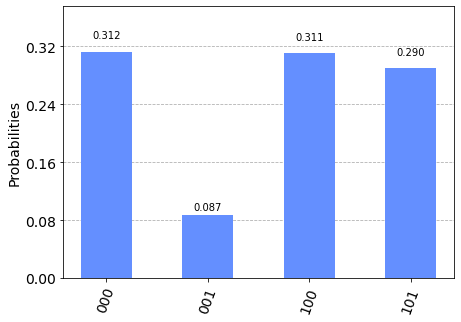

In [20]:
## Simulation of the circuit
simulator = Aer.get_backend('qasm_simulator')

shots = 1024

Sim_result_tomography_circuit=execute(tomography_circuit, backend=simulator,shots=shots).result()

Sim_result_counts_tomography_circuit=Sim_result_tomography_circuit.get_counts(tomography_circuit)

plot_histogram(Sim_result_counts_tomography_circuit).savefig('test_circuit.png',dpi=1200)

plot_histogram(Sim_result_counts_tomography_circuit)

In [8]:
## We build the vector P
p00_test = Sim_result_counts_tomography_circuit['000']/shots
p01_test = Sim_result_counts_tomography_circuit['001']/shots
p10_test = Sim_result_counts_tomography_circuit['100']/shots
p11_test = Sim_result_counts_tomography_circuit['101']/shots

p_test = [p00_test,p01_test,p10_test,p11_test]

U = U_matrix(th_A, th_B)
T = T_matrix(U)
s = np.array(np.matmul(np.linalg.inv(T),p_test))

s1=s[0,1].real
s2=s[0,2].real
s3=s[0,3].real

s_test = [s1,s2,s3]


For comparing the estimation with the initial state of the qubit $S$ we will calculate the fidelity between this quantum states and we are going to graph them in the bloch sphere. The fidelity will be defined as $\mathcal{F} (\rho_0^S,\rho_e^S) = Tr[\sqrt{\sqrt{\rho_0^S} \rho_e^S \sqrt{\rho_0^S}}]^2$, if the states are pure it can be reduced to $\mathcal{F}(\rho_0^S,\rho_e^S) = |\langle{\psi_0^S|\psi_e^S}\rangle|^2.$
First we have to transform the bloch vector into a qubit state of the form $|\psi\rangle = c_0|0\rangle + c_1 |1\rangle. $

In [9]:
def bloch_vector_to_state(s):
    ## We transform the bloch vector into a qubit state
    s1 = s[0]
    s2 = s[1]
    s3 = s[2]
    
    if (s3>0):
        th=np.arctan(np.sqrt(s1*s1 + s2*s2)/s3)
    elif (s3 == 0):
        th = pi/2
    elif (s3 < 0):
        th=np.arctan(np.sqrt(s1*s1 + s2*s2)/s3) + pi

    if (s1>0 and s2>0):
        phi = np.arctan(s2/s1)
    elif (s1>0 and s2<0):
        phi = np.arctan(s2/s1) + 2*pi
    elif (s1 == 0):
        phi = pi/2*np.sign(s2)
    elif (s1<0):
        phi = np.arctan(s2/s1) + pi

    ## We write the alpha and beta amplitudes
    c_0 = np.cos(th/2)
    c_1 = (np.cos(phi) + complex(0,1)*np.sin(phi))*np.sin(th/2)
    
    state = np.array([c_0,c_1])
    return state

def init_ang_to_bloch_vector(angles):
    
    th, phi, lam = angles
    
    s = np.array([np.sin(th)*np.cos(phi), np.sin(th)*np.sin(phi), np.cos(th)])
    
    return s

s_ideal = init_ang_to_bloch_vector(angle_i)
s_ideal

array([1.000000e+00, 0.000000e+00, 6.123234e-17])

Now we find the $c_0$ and $c_1$ component of the initial state of the qubit $S$ from its initialization

In [10]:
## Initialize a 1 qubit circuit
qr = QuantumRegister(1)
cr = ClassicalRegister(1)

qc_i = QuantumCircuit(qr,cr)

## Use the U rotation that we used for initializing the qubit S
qc_i.u(angle_i[0],angle_i[1],angle_i[2],qr[0])

backend = BasicAer.get_backend('statevector_simulator') 
result = execute(qc_i, backend).result()

## Take the statevector
initial_state  = result.get_statevector(qc_i)
estim_state = bloch_vector_to_state(s_test)

print(initial_state,estim_state)
## Calculate the fidelity
fidelity = quantum_info.state_fidelity(initial_state,estim_state)

print('The fidelity betwee the initial state and its estimation is: ',fidelity)

## Save the plots for visualzation
plot_bloch_vector(s_test, title="Estimated state").savefig("estimation_test.png")
plot_bloch_vector(s_ideal, title="Initial state").savefig("initial_test.png")

[0.70710678+0.j 0.70710678+0.j] [0.73786509+0.j         0.64226941-0.20747316j]
The fidelity betwee the initial state and its estimation is:  0.9739081778656794


We now print the bloch spheres of these states
<table>
     <tr>
        <th style="text-align:center" >
            Initial state
        </th>
        <th style="text-align:center">
            Estimation
        </th>
     </tr> 
     <tr>
         <td><img width=350px src='initial_test.png'></td>
         <td><img width=350px src='estimation_test.png'></td>
    </tr>
</table>

As you can see, the estimation model works pretty good even for random values of the parameters $\theta_A$ and $\theta_B$. However, we are interested in finding the best set of parameters for the estimation. Then, we are going to introduce the Fisher error parameter which will be the criteria for finding the best set up for doing qubit state estimation.

## Fisher error
The Fisher information matrix can be defined in different ways. for the purposes of this model we define its components as 
$$F_{\mu\nu}(\mathbf{s}) =  \sum_{j=0}^{3}\frac{1}{p_j} \frac{\partial p_j}{\partial s_\mu} \frac{\partial p_j}{\partial s_\nu}.$$
The Fisher information matrix for this model can be written as
$$\mathbb{F} = \mathbb{D}^T\left(\mathbb{V}\mathbb{P}^{-1}\mathbb{V}^T\right)\mathbb{D},$$

this depends on the measurement matrix $\mathbb{D}$, and the auxiliary matrices $\mathbb{V}$ and  $\mathbb{P}$
$$
		\mathbb{D} = \begin{pmatrix}
			a_1&b_1&c_1\\
			a_2&b_2&c_2\\
			a_3&b_3&c_3
		\end{pmatrix}, \quad
		\mathbb{V} = \begin{pmatrix}
			1 & 1 & -1 & -1\\
			1 & -1 & 1 & -1\\
			1 & -1 & -1 & 1
		\end{pmatrix}, \quad 
		\mathbb{P} =  \begin{pmatrix}
			p_{00} & 0 & 0 & 0 \\
			0 & p_{01} & 0 & 0 \\
			0 & 0 & p_{10} & 0 \\
			0 & 0 & 0 & p_{11}
		\end{pmatrix}.
$$

To study the dependence of the error on the initial state of qubit $S$, we write $c_0= e^{i\alpha_2}\cos\alpha_1$ and $c_1  = e^{- i\alpha_2}\sin\alpha_1$, where $\alpha_1\in [0,\pi/2],$ and $\alpha_2\in [0,\pi]$.

We define the error measure as the trace of the inverse of the Fisher information matrix
$$\Delta (\alpha_1,\alpha_2,\theta_A,\theta_B)=  \operatorname{Tr}(\mathbb{F}^{-1}).$$

Now that we have parametrized the error of this model, we calculate the mean error over all the possible states, this is 
$$\frac{1}{V}\int^{\frac{\pi}{2}}_{0}\int^{\pi}_0 \Delta (\alpha_1,\alpha_2,\theta_A,\theta_B)\sin2\alpha_1d\alpha_1 d\alpha_2.$$

Here the integration Volume is $V = \pi$. Now that we have the mean error in terms of the angles $\theta_A$ and $\theta_B$, we can optimize this in order to find the best set of parameters that minimize the mean error of the estimation model.
To do so we define the objective function to ve optimized.

In [11]:
## We have to parametrized the tomography to find p_ij
def tomography_parametrized(alpha_params, U):
    
    
    c_0 = np.exp(( alpha_params[1])*j)*np.cos(alpha_params[0])
    c_1 =  np.exp((-alpha_params[1])*j)*np.sin(alpha_params[0])
    initial_state = c_0, c_1

    ## Definition of U_{ij}
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## Their adjoints
    
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
    
    ## We define the Kraus operators
    E_00 = (U_00 + U_01 + U_10 + U_11)/4
    E_01 = (U_00 - U_01 + U_10 - U_11)/4
    E_10 = (U_00 + U_01 - U_10 - U_11)/4
    E_11 = (U_00 - U_01 - U_10 + U_11)/4

    ## And their adjoints
    E_00d = (U_00d + U_01d + U_10d + U_11d)/4
    E_01d = (U_00d - U_01d + U_10d - U_11d)/4
    E_10d = (U_00d + U_01d - U_10d - U_11d)/4
    E_11d = (U_00d - U_01d - U_10d + U_11d)/4


    ## The final states of the system are
    d_00 = np.matmul(E_00,initial_state)
    d_01 = np.matmul(E_01,initial_state)
    d_10 = np.matmul(E_10,initial_state)
    d_11 = np.matmul(E_11,initial_state)

    ## So the probabilities p_ij are
    P_00_teo =  d_00[0,0]*d_00[0,0].conjugate() + d_00[0,1]*d_00[0,1].conjugate()
    P_01_teo =  d_01[0,0]*d_01[0,0].conjugate() + d_01[0,1]*d_01[0,1].conjugate()
    P_10_teo =  d_10[0,0]*d_10[0,0].conjugate() + d_10[0,1]*d_10[0,1].conjugate()
    P_11_teo =  d_11[0,0]*d_11[0,0].conjugate() + d_11[0,1]*d_11[0,1].conjugate()

    p_teo = [P_00_teo.real,P_01_teo.real,P_10_teo.real,P_11_teo.real]


    return p_teo

## Definition of the measurement matrix
def D_matrix(U):
    
    ## Definition of U_{ij}
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## Their adjoints
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
    
    A = 1/16*(np.matmul(U_00d,U_10) + np.matmul(U_01d,U_11) + np.matmul(U_10d,U_00) + np.matmul(U_11d,U_01))
    B = 1/16*(np.matmul(U_00d,U_01) + np.matmul(U_01d,U_00) + np.matmul(U_10d,U_11) + np.matmul(U_11d,U_10))
    C = 1/16*(np.matmul(U_00d,U_11) + np.matmul(U_01d,U_10) + np.matmul(U_10d,U_01) + np.matmul(U_11d,U_00))
    
    ## Pauli Matricez
    X = np.matrix([[0,1],[1,0]])
    Y = np.matrix([[0,-complex(0,1)],[complex(0,1),0]])
    Z = np.matrix([[1,0],[0,-1]])
    I = np.matrix([[1,0],[0,1]])

    ## D matrix components
    a0 = 0.5*np.trace(np.matmul(A,I))
    a1 = 0.5*np.trace(np.matmul(A,X))
    a2 = 0.5*np.trace(np.matmul(A,Y))
    a3 = 0.5*np.trace(np.matmul(A,Z))

    b0 = 0.5*np.trace(np.matmul(B,I))
    b1 = 0.5*np.trace(np.matmul(B,X))
    b2 = 0.5*np.trace(np.matmul(B,Y))
    b3 = 0.5*np.trace(np.matmul(B,Z))

    c0 = 0.5*np.trace(np.matmul(C,I))
    c1 = 0.5*np.trace(np.matmul(C,X))
    c2 = 0.5*np.trace(np.matmul(C,Y))
    c3 = 0.5*np.trace(np.matmul(C,Z))

    ## Definition of the D matrix
    D =np.matrix([[a1,a2,a3],[b1,b2,b3],[c1,c2,c3]])
    
    return D

## We now define the fisher error parameter
def error_parameter(D,p):
    
    ## Definition od the auxiliary matrix V
    V = np.matrix([[1,1,-1,-1],[1,-1,1,-1],[1,-1,-1,1]])

    ## Definition od the matrix P
    P = np.matrix([[p[0],0,0,0],[0,p[1],0,0],[0,0,p[2],0],[0,0,0,p[3]]])
    
    ## The Fisher information Matrix
    F = np.matmul(np.matmul(D.transpose(),(np.matmul(np.matmul(V,np.linalg.inv(P)),V.transpose()))),D)
    
    Error = np.abs(np.trace(np.linalg.inv(F)))
    return Error

## Definition of the integrand
def error_integrand(alpha_1,alpha_2,args):
    
    alpha_params = [alpha_1,alpha_2]
    th_A, th_B = args[0],args[1]

    U = U_matrix(th_A, th_B)
    D = D_matrix(U)
    deter = np.linalg.det(D)
    
    p = tomography_parametrized(alpha_params, U)
    error = error_parameter(D,p)*np.sin(2*alpha_1)
    
    return error.real

## Definition of the objective function
def obj_fn(params):
    
    bounds_1 = [0,pi/2]
    bounds_2 = [0,pi]
    
    I = nquad(error_integrand,[bounds_1,bounds_2],args=[params])

    return I[0]/pi

In [12]:
print(obj_fn([3.44819693, -8.4194307]))
print(obj_fn([2*pi/3,pi/4]))

17.001938899655535
322256.39916885295


In [13]:
def optimization(obj_fn, rep):
    
    results=[]
    params = []
    
    for i in range(rep):
        th_A = np.random.uniform(0,2*pi)

        th_B = np.random.uniform(0,2*pi)
        
        init = np.array([th_A, th_B])
        
        res = minimize(obj_fn,init,method='nelder-mead', options={'xatol':1e-4, 'disp': True})
        
        results.append(res.fun)
        params.append(res.x)
    best = min(results)
    best_idx = results.index(best)
    print('results: ',results)
    print('parameters: ',params)
    
    print('best result: ', best)
    print('parameters best result: ',params[best_idx])
    return results, params

In [14]:
optimization(obj_fn, 5)

Optimization terminated successfully.
         Current function value: 19.870210
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 36.766481
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: 19.870210
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 19.870210
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 528.041141
         Iterations: 32
         Function evaluations: 62
results:  [19.870209522960938, 36.76648073781168, 19.87020953671662, 19.87020951904503, 528.0411413342864]
parameters:  [array([2.97060867, 3.96073592]), array([4.38599506, 1.18439415]), array([2.97064938, 3.96072591]), array([2.97064063, 3.96075441]), array([5.38730152, 2.18776591])]
best result:  19.

([19.870209522960938,
  36.76648073781168,
  19.87020953671662,
  19.87020951904503,
  528.0411413342864],
 [array([2.97060867, 3.96073592]),
  array([4.38599506, 1.18439415]),
  array([2.97064938, 3.96072591]),
  array([2.97064063, 3.96075441]),
  array([5.38730152, 2.18776591])])

The code above can be used to find the optimal parameters, it has to be taken into account that it is not an easy task since each evaluation of the cost function implies the evaluation of an integral, and also, you will find out that there ir a big ammount of local minimums. The best minimum that we found is located approximately at $\theta_A = 3.45$ and $\theta_B = -8.42$. This minimum does not have a big error dispersion for all the initial states. The exact value is shown in the code below. 

In [15]:
init = [3.45, -8.42]
minimize(obj_fn,init,method='nelder-mead', options={'xatol':1e-4, 'disp': True})

Optimization terminated successfully.
         Current function value: 16.993293
         Iterations: 28
         Function evaluations: 56


 final_simplex: (array([[ 3.41968803, -8.41648194],
       [ 3.41963129, -8.4164514 ],
       [ 3.41975718, -8.41644286]]), array([16.99329319, 16.99329327, 16.99329332]))
           fun: 16.99329319225016
       message: 'Optimization terminated successfully.'
          nfev: 56
           nit: 28
        status: 0
       success: True
             x: array([ 3.41968803, -8.41648194])

With the optimal values of the system we are now interested in the variation of the error for different initial states with the evolution operator parameters fixed. The plot that shows this behaviour is shown bellow.

In [16]:
def error_graph(alpha_1,alpha_2,args):
    
    alpha_params = [alpha_1,alpha_2]
    th_A, th_B = args[0],args[1]

    U = U_matrix(th_A, th_B)
    D = D_matrix(U)
    deter = np.linalg.det(D)
    
    p = tomography_parametrized(alpha_params, U)
    error = error_parameter(D,p)
    
    return error.real

alpha_1_range = np.linspace(0, pi/2, 40)
alpha_2_range = np.linspace(0, pi, 40)


th_A,th_B = 3.44819693, -8.4194307
params = [th_A,th_B]

Error = np.zeros((alpha_1_range.size, alpha_2_range.size))

x_i=-1
y_i=-1

for alpha_1 in alpha_1_range:
    x_i +=1
    y_i =-1
    for alpha_2 in alpha_2_range:
        y_i+=1
        error = error_graph(alpha_1,alpha_2, params)

        Error[y_i][x_i] = error

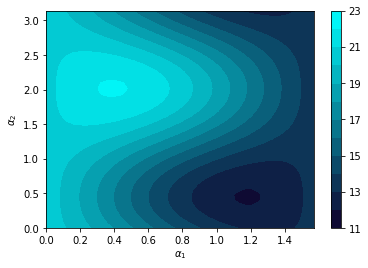

In [23]:
X, Y = np.meshgrid(alpha_1_range, alpha_2_range)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#10002b","cyan"])

plt.contourf(X, Y, Error, 10,linestyles='solid', cmap=cmap)
plt.xlabel(r'$\alpha_1$')
plt.ylabel(r'$\alpha_2$')
#plt.plot(th_a,th_b,'bo',color='white') 

plt.colorbar()

plt.savefig('error_v_init.png')

### Simulation in a quantum device
Now that we have found the best set of parameters $\theta_A = 3.41968803$ and $\theta_B = -8.41648194$. For this set of values, the mean error takes an approximate value of $\Delta \approx 17.$ We are going to execute the model in a local simulator for the six eigenstates of the Pauli matrices, this is,  $X= \left\{|{\psi_{z_0}}\rangle,|{\psi_{z_1}}\rangle,|{\psi_{x_0}}\rangle,|{\psi_{x_1}}\rangle,|{\psi_{y_0}}\rangle,|{\psi_{y_1}}\rangle\right\} = \left\{|0\rangle, |1\rangle, \frac{|0\rangle+|1\rangle}{\sqrt{2}}, \frac{|0\rangle-|1\rangle}{\sqrt{2}}, \frac{|0\rangle+i|1\rangle}{\sqrt{2}}, \frac{|0\rangle-i|1\rangle}{\sqrt{2}}\right\}.$ 

After this, we are going to compare the performance of the model in a real quantum computer, in this case we are going to use the `ibmq_lima` Quantum procesing unit (QPU).

In [38]:
def tg_circuit(angles_i):
    ## We define the tomography circuit as a function
    A = QuantumRegister(1,'a')
    S = QuantumRegister(1,'s')
    B = QuantumRegister(1,'b')
    cr = ClassicalRegister(3)
    
    ## We use the best values of \theta_A and \theta_B
    thA, thB = 3.44819693, -8.4194307
    
    tomography_circuit = QuantumCircuit(A,S,B, cr)

    tomography_circuit.append(Initialization(angles_i),[A,S,B])
    tomography_circuit.barrier()

    tomography_circuit.append(U_operator(thA,thB),[A,S,B])
    tomography_circuit.barrier()

    tomography_circuit.h(A)                     #A
    tomography_circuit.h(B)                     #B
    tomography_circuit.barrier()

    tomography_circuit.measure(A,cr[0])         #A
    tomography_circuit.measure(B,cr[2])         #B
    
    tomography_circuit=transpile(tomography_circuit, basis_gates=['cx','id','rz','sx','x'], optimization_level=3)
    
    return tomography_circuit

def IBM_sim_probs(angles_i, device=0):
    circuit = tg_circuit(angles_i)
    
    shots = 1024
    ## Local simulator
    simulator = Aer.get_backend('qasm_simulator')
    
    ## Quantum simulator
    qcom = provider.get_backend('ibmq_lima') #ibmqx2

    %qiskit_job_watcher
    if device == 0:
        job=execute(circuit, backend=simulator,shots = shots)
    else:
        job=execute(circuit, backend=qcom)

    job_monitor(job)
    sim_result=job.result()
    
    sim_result_counts = sim_result.get_counts(circuit)
    
    if '000' in sim_result_counts:
        p00 = sim_result_counts['000']/shots
    else:
        p00 = 0

    if '001' in sim_result_counts:
        p01 = sim_result_counts['001']/shots
    else:
        p01 = 0
    if '100' in sim_result_counts:
        p10 = sim_result_counts['100']/shots
    else:
        p10 = 0
    if '101' in sim_result_counts:
        p11 = sim_result_counts['101']/shots
    else:
        p11 = 0


    p = [p00,p01,p10,p11]

    return p

def ideal_prob(angles_i):
    
    ## Here we calculate the ideal probabilities of the experiment
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)

    qc_i = QuantumCircuit(qr,cr)
    
    qc_i.u(angles_i[0],angles_i[1],angles_i[2],qr[0])
    
    backend = BasicAer.get_backend('statevector_simulator') 
    result = execute(qc_i, backend).result()
    
    thA, thB = 3.44819693, -8.4194307
    
    U = U_matrix(thA, thB)
    
    ## Tomamos el estado asociado
    initial_state  = result.get_statevector(qc_i)
    alpha,beta = initial_state[0],initial_state[1]

    ## Se definen los operadores U_{ij}
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## Y sus adjuntos dado que los necesitaremos luego
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
    
    ## Definimos los operadores de Kraus
    E_00 = (U_00 + U_01 + U_10 + U_11)/4
    E_01 = (U_00 - U_01 + U_10 - U_11)/4
    E_10 = (U_00 + U_01 - U_10 - U_11)/4
    E_11 = (U_00 - U_01 - U_10 + U_11)/4

    ## Y sus conjugados
    E_00d = (U_00d + U_01d + U_10d + U_11d)/4
    E_01d = (U_00d - U_01d + U_10d - U_11d)/4
    E_10d = (U_00d + U_01d - U_10d - U_11d)/4
    E_11d = (U_00d - U_01d - U_10d + U_11d)/4


    ## Los estados finales del sistema son
    d_00 = np.matmul(E_00,initial_state)
    d_01 = np.matmul(E_01,initial_state)
    d_10 = np.matmul(E_10,initial_state)
    d_11 = np.matmul(E_11,initial_state)


    P_00_teo =  d_00[0,0]*d_00[0,0].conjugate() + d_00[0,1]*d_00[0,1].conjugate()
    P_01_teo =  d_01[0,0]*d_01[0,0].conjugate() + d_01[0,1]*d_01[0,1].conjugate()
    P_10_teo =  d_10[0,0]*d_10[0,0].conjugate() + d_10[0,1]*d_10[0,1].conjugate()
    P_11_teo =  d_11[0,0]*d_11[0,0].conjugate() + d_11[0,1]*d_11[0,1].conjugate()

    p_teo = [P_00_teo.real,P_01_teo.real,P_10_teo.real,P_11_teo.real]


    return p_teo 

def bloch_vector_from_prob(p):
    ## best angles
    thA, thB = 3.44819693, -8.4194307
    U = U_matrix(thA, thB)
    T = T_matrix(U)
    s = np.array(np.matmul(np.linalg.inv(T),p))
    
    s1=s[0,1].real
    s2=s[0,2].real
    s3=s[0,3].real

    s = [s1,s2,s3]
    
    return s

In [77]:
## Initial angles for Pauli matrices eigenstates 
ang_z0 = [0,0,0]
ang_z1 = [pi,0,0]
ang_x0 = [pi/2,0,0]
ang_x1 = [-pi/2,0,0]
ang_y0 = [-pi/2,-pi/2,pi/2]
ang_y1 = [pi/2,-pi/2,pi/2]

## We recalculate the T matrix
thA, thB = 3.44819693, -8.4194307
U = U_matrix(thA, thB)
T = np.array(T_matrix(U))

In [42]:
## File where the results will be stored
file = open("data_s_sim.txt","a")

## IBMQ provider
provider=IBMQ.get_provider('ibm-q')

angles = [ang_z0,ang_z1,ang_x0,ang_x1,ang_y0,ang_y1]
states=['z0','z1','x0','x1','y0','y1']

state = 0
for a_i in angles:
    
    for n in range(5):
        
        p_ideal = ideal_prob(a_i)
        p_IBM = IBM_sim_probs(a_i,0)

        s_real = bloch_vector_from_prob(p_ideal)
        s_IBM = bloch_vector_from_prob(p_IBM)
        
        ideal_state = bloch_vector_to_state(s_real)
        rec_IBM_state = bloch_vector_to_state(s_IBM)
        
        fidelity_ibm = quantum_info.state_fidelity(ideal_state,rec_IBM_state)
        
        file.write("%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s  \n" % (states[state], p_ideal[0], p_ideal[1],p_ideal[2], p_ideal[3],  p_IBM[0], p_IBM[1],p_IBM[2], p_IBM[3], s_real[0],s_real[1],s_real[2], s_IBM[0],s_IBM[1],s_IBM[2], fidelity_ibm))
        
        print('s ideal: ', s_real)
        print('s simulation: ', s_IBM)
        print('Local simulation fidelity: ',fidelity_ibm)
        
        print('State: ', states[state], 'run: ',n+1,' Finished.')
    state += 1
file.close()    

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, -1.1102230246251565e-16, 0.9999999999999999]
s simulation:  [0.073697819745566, -0.08681039562301876, 1.0562828813577725]
Local simulation fidelity:  0.9971195040550281
State:  z0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, -1.1102230246251565e-16, 0.9999999999999999]
s simulation:  [-0.04158503522810597, 0.06363957170012535, 0.8913133871524821]
Local simulation fidelity:  0.9981911877083263
State:  z0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, -1.1102230246251565e-16, 0.9999999999999999]
s simulation:  [-0.10848882090645318, -0.18099494360236998, 1.0667314902169824]
Local simulation fidelity:  0.990495055050126
State:  z0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, -1.1102230246251565e-16, 0.9999999999999999]
s simulation:  [-0.006634629522759505, 0.03929108252433777, 0.9288056571888137]
Local simulation fidelity:  0.9995404961592339
State:  z0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, -1.1102230246251565e-16, 0.9999999999999999]
s simulation:  [0.06160972288914901, -0.06286164623513296, 0.9141398887667208]
Local simulation fidelity:  0.997698237290995
State:  z0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [5.551115123125783e-16, 2.220446049250313e-16, -0.9999999999999999]
s simulation:  [0.15030758691709512, 0.014548837815117066, -0.954217565323326]
Local simulation fidelity:  0.9938540142540514
State:  z1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [5.551115123125783e-16, 2.220446049250313e-16, -0.9999999999999999]
s simulation:  [0.013470123232119213, -0.00893011685394507, -0.9518113437830188]
Local simulation fidelity:  0.9999279385639762
State:  z1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [5.551115123125783e-16, 2.220446049250313e-16, -0.9999999999999999]
s simulation:  [-0.04231069159255707, -0.0022312103684527518, -0.9962616405604116]
Local simulation fidelity:  0.9995484448018688
State:  z1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [5.551115123125783e-16, 2.220446049250313e-16, -0.9999999999999999]
s simulation:  [-0.010865021056819024, -0.03409349647758886, -0.989543195383579]
Local simulation fidelity:  0.9996734154410237
State:  z1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [5.551115123125783e-16, 2.220446049250313e-16, -0.9999999999999999]
s simulation:  [0.004439047806429841, -0.05061720355895616, -0.9383455643616727]
Local simulation fidelity:  0.9992685506294028
State:  z1 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.0, 1.6653345369377348e-16, -5.551115123125783e-17]
s simulation:  [1.008268912519323, -0.020254890028121864, 0.06087332391367084]
Local simulation fidelity:  0.99899091538804
State:  x0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.0, 1.6653345369377348e-16, -5.551115123125783e-17]
s simulation:  [0.9551884033775604, 0.06214141484447305, -0.056327180893291584]
Local simulation fidelity:  0.9980836235895267
State:  x0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.0, 1.6653345369377348e-16, -5.551115123125783e-17]
s simulation:  [0.9838883875981563, -0.031746047510282926, 0.051124340306754834]
Local simulation fidelity:  0.9990673439190135
State:  x0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.0, 1.6653345369377348e-16, -5.551115123125783e-17]
s simulation:  [1.0448716935270355, -0.03539701202597095, -0.07899660578713508]
Local simulation fidelity:  0.998292875957542
State:  x0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.0, 1.6653345369377348e-16, -5.551115123125783e-17]
s simulation:  [1.0101749649953633, -0.04199636139838181, -0.0033821415566154256]
Local simulation fidelity:  0.9995656782205725
State:  x0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999997, -3.3306690738754696e-16, -9.020562075079397e-17]
s simulation:  [-1.1223685796565799, 0.04228672846332793, -0.008641521003037165]
Local simulation fidelity:  0.9996307130297003
State:  x1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999997, -3.3306690738754696e-16, -9.020562075079397e-17]
s simulation:  [-1.1171970908450615, 0.05854746048806059, 0.07518729219578082]
Local simulation fidelity:  0.9981909566357683
State:  x1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999997, -3.3306690738754696e-16, -9.020562075079397e-17]
s simulation:  [-1.0329802636165897, 0.03361774551252228, 0.1505776960618058]
Local simulation fidelity:  0.9945145884289379
State:  x1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999997, -3.3306690738754696e-16, -9.020562075079397e-17]
s simulation:  [-0.9807412526171799, 0.026700585250977293, -0.05217158609993494]
Local simulation fidelity:  0.9991096294831258
State:  x1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999997, -3.3306690738754696e-16, -9.020562075079397e-17]
s simulation:  [-1.119160919626318, 0.05608844975403349, 0.14482173950109595]
Local simulation fidelity:  0.9952542903012157
State:  x1 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, 0.9999999999999998, -4.371503159461554e-16]
s simulation:  [-0.08567715673002152, 0.8885449844545221, 0.10475869921292424]
Local simulation fidelity:  0.9942995346800895
State:  y0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, 0.9999999999999998, -4.371503159461554e-16]
s simulation:  [0.04847251530833352, 0.9951129008768568, 0.04909247625701278]
Local simulation fidelity:  0.9988026842036696
State:  y0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, 0.9999999999999998, -4.371503159461554e-16]
s simulation:  [-0.020578485983436035, 0.9619540556331951, 0.04964910107977394]
Local simulation fidelity:  0.9992214445801978
State:  y0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, 0.9999999999999998, -4.371503159461554e-16]
s simulation:  [-0.03431673874905283, 1.1801916133000288, -0.004546581063877033]
Local simulation fidelity:  0.9997850566504961
State:  y0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, 0.9999999999999998, -4.371503159461554e-16]
s simulation:  [-0.009907549291673146, 0.8540611493757697, -0.015168668633535748]
Local simulation fidelity:  0.9998875349267626
State:  y0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [3.3306690738754696e-16, -0.9999999999999996, 1.6653345369377348e-16]
s simulation:  [-0.07316117608948614, -0.9885861564631979, 0.1483671097216418]
Local simulation fidelity:  0.9931434349033156
State:  y1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [3.3306690738754696e-16, -0.9999999999999996, 1.6653345369377348e-16]
s simulation:  [0.20924156684052975, -1.0204841388549435, -0.07343339168163043]
Local simulation fidelity:  0.988597238889968
State:  y1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [3.3306690738754696e-16, -0.9999999999999996, 1.6653345369377348e-16]
s simulation:  [0.16203381905953562, -1.0005389633741744, 0.03008079942796682]
Local simulation fidelity:  0.9933523245349991
State:  y1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [3.3306690738754696e-16, -0.9999999999999996, 1.6653345369377348e-16]
s simulation:  [-0.05676787990987897, -0.996540437706841, 0.009181356225578141]
Local simulation fidelity:  0.9991696008889039
State:  y1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [3.3306690738754696e-16, -0.9999999999999996, 1.6653345369377348e-16]
s simulation:  [-0.008213143942434664, -0.9946146426681275, 0.09540302309675636]
Local simulation fidelity:  0.9976987959604863
State:  y1 run:  5  Finished.


In [43]:
## File where the results will be stored
file = open("data_s_qpu.txt","a")

## IBMQ provider
provider=IBMQ.get_provider('ibm-q')

angles = [ang_z0,ang_z1,ang_x0,ang_x1,ang_y0,ang_y1]
states=['z0','z1','x0','x1','y0','y1']

state = 0
for a_i in angles:
    
    for n in range(5):
        
        p_ideal = ideal_prob(a_i)
        p_IBM = IBM_sim_probs(a_i, 1)

        s_real = bloch_vector_from_prob(p_ideal)
        s_IBM = bloch_vector_from_prob(p_IBM)
        
        ideal_state = bloch_vector_to_state(s_real)
        rec_IBM_state = bloch_vector_to_state(s_IBM)
        
        fidelity_ibm = quantum_info.state_fidelity(ideal_state,rec_IBM_state)
        
        file.write("%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s  \n" % (states[state], p_ideal[0], p_ideal[1],p_ideal[2], p_ideal[3],  p_IBM[0], p_IBM[1],p_IBM[2], p_IBM[3], s_real[0],s_real[1],s_real[2], s_IBM[0],s_IBM[1],s_IBM[2], fidelity_ibm))
        
        print('s ideal: ', s_real)
        print('s simulation: ', s_IBM)
        print('QPU simulation fidelity: ',fidelity_ibm)
        
        print('State: ', states[state], 'run: ',n+1,' Finished.')
    state += 1
file.close() 

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, -1.1102230246251565e-16, 0.9999999999999999]
s simulation:  [-0.18161728981713599, 0.5478862235645489, 0.16840385193211455]
QPU simulation fidelity:  0.640040435214382
State:  z0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, -1.1102230246251565e-16, 0.9999999999999999]
s simulation:  [-0.11029709884862327, 0.7866285775393999, 0.3609342650194026]
QPU simulation fidelity:  0.7068435679878246
State:  z0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, -1.1102230246251565e-16, 0.9999999999999999]
s simulation:  [0.12747995652649347, 0.11482240577164404, 0.8645269820711092]
QPU simulation fidelity:  0.9904357771331298
State:  z0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, -1.1102230246251565e-16, 0.9999999999999999]
s simulation:  [-0.2553034321673776, 0.6774794168158598, 0.4749513170350954]
QPU simulation fidelity:  0.7742613701214976
State:  z0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, -1.1102230246251565e-16, 0.9999999999999999]
s simulation:  [0.22996116478481565, 0.15007400090177953, 0.579249619205202]
QPU simulation fidelity:  0.951803382606078
State:  z0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [5.551115123125783e-16, 2.220446049250313e-16, -0.9999999999999999]
s simulation:  [-0.13155890040274937, -0.11124316650674404, -0.8238028577705039]
QPU simulation fidelity:  0.9894116175103376
State:  z1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [5.551115123125783e-16, 2.220446049250313e-16, -0.9999999999999999]
s simulation:  [-1.4003258055274275, 0.4301146530381367, 0.5960995858935692]
QPU simulation fidelity:  0.3115437055075888
State:  z1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [5.551115123125783e-16, 2.220446049250313e-16, -0.9999999999999999]
s simulation:  [-2.2105968727881473, 0.7389103224900823, 0.9181392876300021]
QPU simulation fidelity:  0.3167486195473613
State:  z1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [5.551115123125783e-16, 2.220446049250313e-16, -0.9999999999999999]
s simulation:  [-1.1628185516054754, 0.06987520002666847, 0.251126887476548]
QPU simulation fidelity:  0.3946329951196825
State:  z1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [5.551115123125783e-16, 2.220446049250313e-16, -0.9999999999999999]
s simulation:  [-2.5879126444375933, 0.3442308940448308, 1.6786157649784854]
QPU simulation fidelity:  0.22958647943768679
State:  z1 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.0, 1.6653345369377348e-16, -5.551115123125783e-17]
s simulation:  [-0.05118919819301504, 0.42876532665522726, 0.4825110151370656]
QPU simulation fidelity:  0.46047263595269344
State:  x0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.0, 1.6653345369377348e-16, -5.551115123125783e-17]
s simulation:  [0.24643306328250147, 0.31872988291861165, 0.06426605235565674]
QPU simulation fidelity:  0.8020157103561977
State:  x0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.0, 1.6653345369377348e-16, -5.551115123125783e-17]
s simulation:  [-0.07186896871281068, 0.49055330134853453, 0.4734074768877397]
QPU simulation fidelity:  0.44757983587529787
State:  x0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.0, 1.6653345369377348e-16, -5.551115123125783e-17]
s simulation:  [0.33490548092178274, 0.3740929204429429, 0.3977317084333829]
QPU simulation fidelity:  0.7614223503534766
State:  x0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.0, 1.6653345369377348e-16, -5.551115123125783e-17]
s simulation:  [0.10113983110422231, 0.050246175341311816, 0.41299131546433576]
QPU simulation fidelity:  0.6181115351977571
State:  x0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999997, -3.3306690738754696e-16, -9.020562075079397e-17]
s simulation:  [-1.6270449163501128, 0.11399995864590684, 0.8893325967231547]
QPU simulation fidelity:  0.9379106561557334
State:  x1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999997, -3.3306690738754696e-16, -9.020562075079397e-17]
s simulation:  [-1.2887149220556087, -0.01032241197229089, 0.5914384679609057]
QPU simulation fidelity:  0.9544164754535474
State:  x1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999997, -3.3306690738754696e-16, -9.020562075079397e-17]
s simulation:  [-1.6477042159469606, -0.03454335318841384, 0.9556525137667434]
QPU simulation fidelity:  0.9324463039442533
State:  x1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999997, -3.3306690738754696e-16, -9.020562075079397e-17]
s simulation:  [-1.6994046335797277, 0.13909265171101637, 0.8289870171845078]
QPU simulation fidelity:  0.9481722889812281
State:  x1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999997, -3.3306690738754696e-16, -9.020562075079397e-17]
s simulation:  [-1.6158414788751108, 0.3826977514674401, 0.6500937810494104]
QPU simulation fidelity:  0.9530578022972089
State:  x1 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, 0.9999999999999998, -4.371503159461554e-16]
s simulation:  [-0.3569593849261423, 0.7264539013881581, 0.4933338812716184]
QPU simulation fidelity:  0.8831871227137672
State:  y0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, 0.9999999999999998, -4.371503159461554e-16]
s simulation:  [-0.6731120740577415, 0.5535940679828222, 0.5067164474262157]
QPU simulation fidelity:  0.7745672915641195
State:  y0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, 0.9999999999999998, -4.371503159461554e-16]
s simulation:  [-0.3111606036965371, 0.49527423415905686, 0.0870644013881702]
QPU simulation fidelity:  0.9187640125688897
State:  y0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, 0.9999999999999998, -4.371503159461554e-16]
s simulation:  [-0.713751972654996, 0.3055453498629692, 0.6416195026241678]
QPU simulation fidelity:  0.6516788115793383
State:  y0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [2.220446049250313e-16, 0.9999999999999998, -4.371503159461554e-16]
s simulation:  [-0.4787441191650722, 1.041807909537419, 0.19580201467345443]
QPU simulation fidelity:  0.9478423028252736
State:  y0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [3.3306690738754696e-16, -0.9999999999999996, 1.6653345369377348e-16]
s simulation:  [-0.8252891398278581, -0.18384149769702884, 0.4139494252647028]
QPU simulation fidelity:  0.5976415022790793
State:  y1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [3.3306690738754696e-16, -0.9999999999999996, 1.6653345369377348e-16]
s simulation:  [-1.121704638710028, -0.05516780024643897, 0.8388663417759252]
QPU simulation fidelity:  0.5196778953422427
State:  y1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [3.3306690738754696e-16, -0.9999999999999996, 1.6653345369377348e-16]
s simulation:  [-1.1908605690996183, 0.3970936440073363, 0.9975628662352168]
QPU simulation fidelity:  0.37617311490045513
State:  y1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [3.3306690738754696e-16, -0.9999999999999996, 1.6653345369377348e-16]
s simulation:  [-0.3800244633292086, -0.2860999776700311, 0.4151522038679697]
QPU simulation fidelity:  0.7265721751795237
State:  y1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [3.3306690738754696e-16, -0.9999999999999996, 1.6653345369377348e-16]
s simulation:  [-0.13198022143944277, -0.29393139371888355, 0.6297149933621113]
QPU simulation fidelity:  0.7077670511005475
State:  y1 run:  5  Finished.


As you can see, the estimated states does not make any sense. This is due to the depth of the circuit needed to do this simulation. Moreover, it requiere a great ammount of CNOT gates, so, when the system is simulated in a quantum computer, all of this errors get accumulated and give a really noisy result. Due to this reason, before analizing the results, we are going to use another estimation method called maximum-likelihood estimation [REFERENCE MLE].

In [78]:
## Function for maximun-likeihood estimation
def disc_ML_est(mm,freq):
    ## mm = measurement matrix
    ## freq = probabilities from the experiment
    se = np.array([1.0,0.0,0.0,0.0])
    nint = 10000
    for k in range(1,nint):
        pe = np.dot(mm,se)
        
        re = np.dot(np.transpose(mm),(freq/pe))

        ge = re[1]**2 + re[2]**2 + re[3]**2 - re[0]**2 
        se[1] = (2*re[1]-se[1]*ge)/(2*re[0]+ge)
        se[2] = (2*re[2]-se[2]*ge)/(2*re[0]+ge)
        se[3] = (2*re[3]-se[3]*ge)/(2*re[0]+ge)
    return se

## dataframes for local and qpu simulations respectively
df_sim = pd.read_csv('data_s_sim.txt', delimiter = ",",names=['state','p_00_ideal','p_01_ideal','p_10_ideal','p_11_ideal','p_00_qpu','p_01_qpu','p_10_qpu','p_11_qpu','s1_ideal','s2_ideal','s3_ideal','s1_qpu_le','s2_qpu_le','s3_qpu_le','fidelity_le'])
df = pd.read_csv('data_s_qpu.txt', delimiter = ",",names=['state','p_00_ideal','p_01_ideal','p_10_ideal','p_11_ideal','p_00_qpu','p_01_qpu','p_10_qpu','p_11_qpu','s1_ideal','s2_ideal','s3_ideal','s1_qpu_le','s2_qpu_le','s3_qpu_le','fidelity_le'])

In [79]:
## Implementation of maximum-likelihood estimation algorithm
def s_from_df_qpu(row,i):
    freq = np.array([row['p_00_qpu'],row['p_01_qpu'],row['p_10_qpu'],row['p_11_qpu']])
    return disc_ML_est(np.array(T),freq)[i]

df['s0_qpu_ml'] = df.apply(lambda x: s_from_df_qpu(x,0),axis=1)
df['s1_qpu_ml'] = df.apply(lambda x: s_from_df_qpu(x,1),axis=1)
df['s2_qpu_ml'] = df.apply(lambda x: s_from_df_qpu(x,2),axis=1)
df['s3_qpu_ml'] = df.apply(lambda x: s_from_df_qpu(x,3),axis=1)


df_sim['s0_sim_ml'] = df_sim.apply(lambda x: s_from_df_qpu(x,0),axis=1)
df_sim['s1_sim_ml'] = df_sim.apply(lambda x: s_from_df_qpu(x,1),axis=1)
df_sim['s2_sim_ml'] = df_sim.apply(lambda x: s_from_df_qpu(x,2),axis=1)
df_sim['s3_sim_ml'] = df_sim.apply(lambda x: s_from_df_qpu(x,3),axis=1)


<ipython-input-78-c559a7369ece>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  se[1] = (2*re[1]-se[1]*ge)/(2*re[0]+ge)
<ipython-input-78-c559a7369ece>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  se[2] = (2*re[2]-se[2]*ge)/(2*re[0]+ge)
<ipython-input-78-c559a7369ece>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  se[3] = (2*re[3]-se[3]*ge)/(2*re[0]+ge)


In [84]:
## Fidelities of the new estimated states
def fidelity_qpu_ml(row):
    s_ideal = [row['s1_ideal'],row['s2_ideal'],row['s3_ideal']]
    s_IBM = [row['s1_qpu_ml'],row['s2_qpu_ml'],row['s3_qpu_ml']]
    ideal_state = bloch_vector_to_state(s_ideal)
    rec_IBM_state = bloch_vector_to_state(s_IBM)
    return quantum_info.state_fidelity(ideal_state,rec_IBM_state)

def fidelity_sim_ml(row):
    s_ideal = [row['s1_ideal'],row['s2_ideal'],row['s3_ideal']]
    s_IBM = [row['s1_sim_ml'],row['s2_sim_ml'],row['s3_sim_ml']]
    ideal_state = bloch_vector_to_state(s_ideal)
    rec_IBM_state = bloch_vector_to_state(s_IBM)

    return quantum_info.state_fidelity(ideal_state,rec_IBM_state)

df['fidelity_qpu_ml'] = df.apply(fidelity_qpu_ml, axis=1)
df_sim['fidelity_sim_ml'] = df_sim.apply(fidelity_sim_ml, axis=1)

grouped_df = df.groupby(['state'],sort=False).mean()
grouped_df_sim = df_sim.groupby(['state'],sort=False).mean()

In [85]:
grouped_df_sim = grouped_df_sim.round(3)
grouped_df_sim[['s1_ideal','s1_sim_ml','s2_ideal', 's2_sim_ml','s3_ideal', 's3_sim_ml','fidelity_sim_ml']]

,s1_ideal,s1_sim_ml,s2_ideal,s2_sim_ml,s3_ideal,s3_sim_ml,fidelity_sim_ml
state,,,,,,,
z0,0.0,0.009,-0.0,-0.031,1.0,0.943,0.997
z1,0.0,0.023,0.0,-0.016,-1.0,-0.966,0.998
x0,1.0,0.986,0.0,-0.009,-0.0,-0.008,0.999
x1,-1.0,-0.993,-0.0,0.040,-0.0,0.022,0.998
y0,0.0,-0.014,1.0,0.940,-0.0,0.046,0.998
y1,0.0,0.012,-1.0,-0.994,0.0,0.054,0.997


In [86]:
grouped_df = grouped_df.round(3)
grouped_df[['s1_ideal','s1_qpu_ml','s2_ideal', 's2_qpu_ml','s3_ideal', 's3_qpu_ml','fidelity_qpu_ml']]

,s1_ideal,s1_qpu_ml,s2_ideal,s2_qpu_ml,s3_ideal,s3_qpu_ml,fidelity_qpu_ml
state,,,,,,,
z0,0.0,-0.038,-0.0,0.455,1.0,0.490,0.813
z1,0.0,-0.707,0.0,0.190,-1.0,0.138,0.447
x0,1.0,0.112,0.0,0.332,-0.0,0.366,0.618
x1,-1.0,-0.892,-0.0,0.097,-0.0,0.422,0.946
y0,0.0,-0.486,1.0,0.595,-0.0,0.385,0.836
y1,0.0,-0.546,-1.0,-0.092,0.0,0.561,0.576
